In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

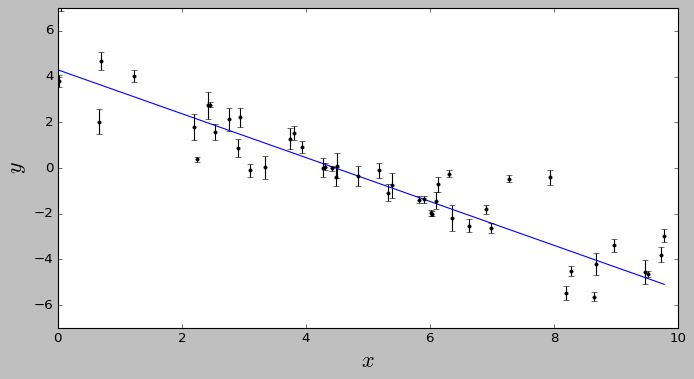

In [2]:
plt.style.use('classic')
plt.figure(figsize=(10,5))
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
plt.plot(x,y)
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)
plt.errorbar(x,y,yerr,fmt='.k')
plt.xlabel('$x$',fontsize = 20)
plt.ylabel('$y$',fontsize = 20)
plt.ylim(-7,7)
plt.xlim(0,10)
plt.show()

In [3]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

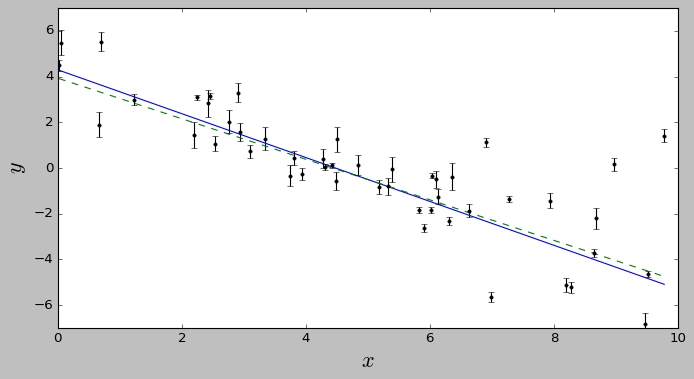

In [4]:
plt.figure(figsize=(10,5))
y = m_true*x+b_true
plt.plot(x,y)
y1=m_ls*x+b_ls
plt.plot(x,y1,'--')
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)
plt.errorbar(x,y,yerr,fmt='.k')
plt.xlabel('$x$',fontsize = 20)
plt.ylabel('$y$',fontsize = 20)
plt.ylim(-7,7)
plt.xlim(0,10)
plt.show()

### Maximum Likelihood estimation 

$ln\, p(y\mid x,\sigma ,m,b,f)=-\frac{1}{2}\sum_{n}^{N}\left [ \frac{(y_{n}-mx_{n}-b)^{2}}{s_{n}^{2}} +ln(2\pi s_{n}^{2})\right]$

#### Donde:

$s_{n}^{2}=\sigma _{n}^{2}+f^{2}(mx_{n}+b)^{2}$

In [5]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

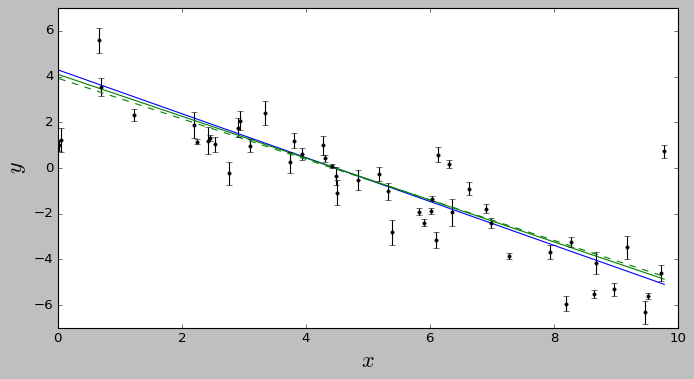

In [7]:
plt.figure(figsize=(10,5))
y = m_true*x+b_true
plt.plot(x,y)
y1=m_ls*x+b_ls
y2=m_ml*x+b_ml
plt.plot(x,y1,'--')
plt.plot(x,y2, color='g')
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)
plt.errorbar(x,y,yerr,fmt='.k')
plt.xlabel('$x$',fontsize = 20)
plt.ylabel('$y$',fontsize = 20)
plt.ylim(-7,7)
plt.xlim(0,10)
plt.show()

### Marginalization & uncertainty estimation 

$p(m,b,f\mid x,y,\sigma )\propto p(m,b,f)p(y\mid x,\sigma ,m,b,f)$

$p(m)=\left\{\begin{matrix}
1/5.5, & if -5<m<1/2 \\ 
0, & otherwise 
\end{matrix}\right.$

In [8]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [9]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [10]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [11]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [12]:
sampler.run_mcmc(pos, 500)
print()

()


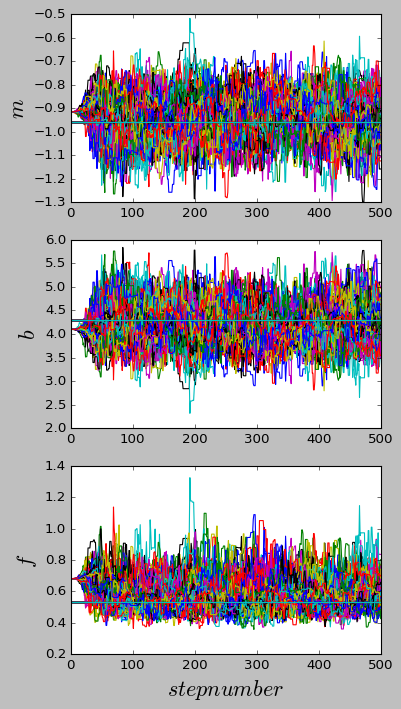

In [13]:
x1 = np.linspace(0.0, 500, 500)
plt.figure(figsize=(5,10))
for i in range(100):
    plt.subplot(3, 1, 1)
    plt.plot(x1, sampler.chain[i,:,0], '-')
    plt.plot(x1, -0.9594*np.ones(500), '-')
    plt.ylabel('$m$',fontsize = 20)

    plt.subplot(3, 1, 2)
    plt.plot(x1, sampler.chain[i,:,1], '-')
    plt.plot(x1, 4.294*np.ones(500), '-')
    plt.ylabel('$b$',fontsize = 20)

    plt.subplot(3, 1, 3)
    plt.plot(x1, np.exp(sampler.chain[i,:,2]), '-')
    plt.plot(x1, 0.534*np.ones(500), '-')
    plt.xlabel('$stepnumber$',fontsize = 20)
    plt.ylabel('$f$',fontsize = 20)
plt.show()

In [14]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

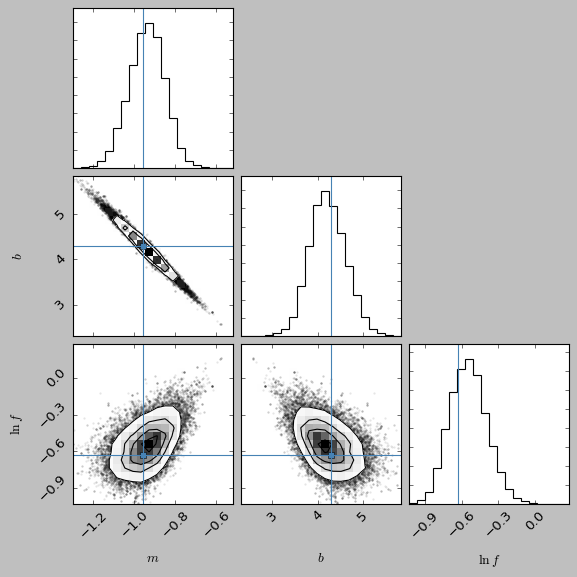

In [15]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

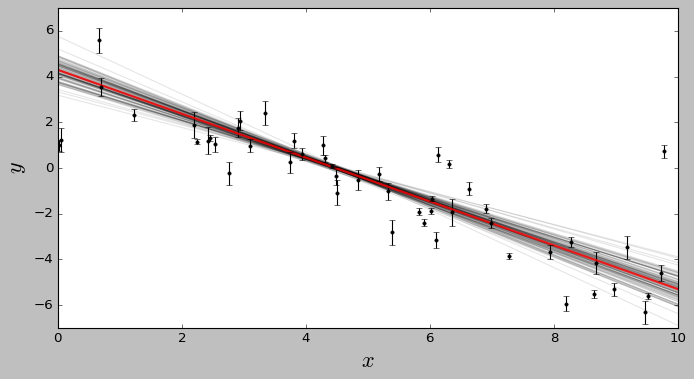

In [16]:
plt.figure(figsize=(10,5))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel('$x$',fontsize = 20)
plt.ylabel('$y$',fontsize = 20)
plt.ylim(-7,7)
plt.xlim(0,10)
plt.show()

In [17]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))